In [1]:
!pip install torch
!pip install pathlib
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
import torch.nn.functional as F

## Test Baseline

In [3]:
import pandas as pd
df = pd.read_csv(r"allfiles.csv")
df

,Unnamed: 0,doc_id,text,is_hate
0,0,12834217_1,"As of March 13th , 2014 , the booklet had been...",0
1,1,12834217_10,Thank you in advance. : ) Download the youtube...,0
2,2,12834217_2,In order to help increase the booklets downloa...,0
3,3,12834217_3,( Simply copy and paste the following text int...,0
4,4,12834217_4,Click below for a FREE download of a colorfull...,1
...,...,...,...,...
10939,10939,33677015_1,Apparently he came to the conclusion that his ...,0
10940,10940,33677019_1,Wish we at least had a Marine Le Pen to vote f...,0
10941,10941,33677019_2,Its like the choices are white genocide candid...,0
10942,10942,33677053_1,Why White people used to say that sex was a si...,1


In [4]:
df.is_hate.sum() / len(df)

0.10928362573099415

In [21]:
pd.set_option("max_colwidth", 100)
df[df.is_hate == 1]

,Unnamed: 0,doc_id,text,is_hate
4,4,12834217_4,Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engin...,1
12,12,12834278_3,Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engin...,1
19,19,12834493_1,"She may or may not be a Jew but she 's certainly stupid , she seems to think the Blacks wo n't k...",1
21,21,12834922_2,God knows what would come out of Africa if only blacks could come up with investigative journali...,1
24,24,12835050_1,I'm insulted by how stupid the Jews think we are until I see what they see by reading the posts ...,1
...,...,...,...,...
10902,10902,33633437_1,Meanwhile those nonwhites continue to breed even as their nonwhite societies continue to inflict...,1
10904,10904,33633437_3,Their nonwhite societies are failing in every area and yet they are trying to force White civili...,1
10922,10922,33645552_1,We can turn the cold useless parts of Canada into a dumping ground for Jews and arm the Indians ...,1
10929,10929,33661937_1,I would move too but unfortunately there is nowhere that is untainted .,1


In [22]:
max([len(str(i).split(" ")) for i in list(df.text)])

349

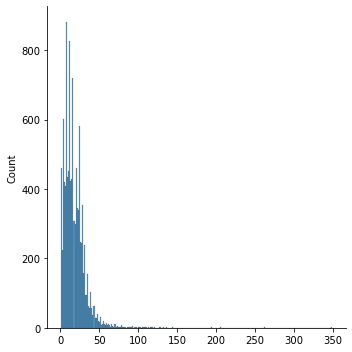

In [8]:
import seaborn as sns
sns.displot([len(str(i).split(" ")) for i in list(df.text)])

In [11]:
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
id2del = [3400] # df.text[3400] == nan

for i in range(len(df)):
    if i != 3400:
        tokens = tokenizer.encode_plus(df.text[i], add_special_tokens=False,
                                   return_tensors='pt')
        if len(tokens['input_ids'][0]) >= 512:
               id2del.append(i)
id2del

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


[3400, 327]

In [13]:
df = df.drop(id2del)

In [15]:
y_pred = []
for x in list(df.text):
    y_pred.append(classifier(x)[0]["label"])

In [54]:
df = df.drop(id2del)

In [55]:
model_names = ["distilbert-base-uncased-finetuned-sst-2-english"]          
scores =  []
for model_name in model_names:
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = classifier(list(df.text))
    scores.append(results)

In [22]:
y_pred = [1 if x == 'LABEL_1' else 0 for x in y_pred]

In [25]:
y_truth = list(df.is_hate)

In [29]:
from sklearn.metrics import f1_score
print(f1_score(y_truth, y_pred, average="macro"))
f1_score(y_truth, y_pred, average="binary")

0.3315388460748794


0.12963205447165116

In [27]:
sum([1 if y_truth[i] == y_pred[i] else 0 for i in range(len(y_pred))]) / len(y_pred)

0.3925242186072016